In [35]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import os
from env import host, user, password
import acquire_lesson_functions as a
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

from tabulate import tabulate


#import summarize
#import prepare

# Zillow Exercises

For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.

You will have a zillow.ipynb file and a helper file for each section in the pipeline.

# Acquire & summarize

## Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

- Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
- Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction.
- Only include properties that include a latitude and longitude value.

In [5]:
#function to connect to codeup db
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [6]:
def new_zillow_data():
    '''
    This function reads the zillow data from the Codeup db into a df,
    write it to a csv file, and returns the df.
    '''
    # Create SQL query.
    sql_query = """
    SELECT prop.*,
       pred.logerror AS log_error,
       pred.transactiondate AS transaction_date,
       air.airconditioningdesc AS air_conditioning_type,
       arch.architecturalstyledesc AS archetectural_style,
       build.buildingclassdesc AS building_class,
       heat.heatingorsystemdesc AS heating_type,
       landuse.propertylandusedesc AS property_type,
       story.storydesc AS number_of_stories,
       construct.typeconstructiondesc AS construction_type
    FROM   properties_2017 prop
           INNER JOIN (SELECT parcelid,
                       Max(transactiondate) transactiondate
                       FROM   predictions_2017
                       GROUP  BY parcelid) pred
                   USING (parcelid)
                        JOIN predictions_2017 as pred USING (parcelid, transactiondate)
           LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
           LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
           LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
           LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
           LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid)
           LEFT JOIN storytype story USING (storytypeid)
           LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
    WHERE  prop.latitude IS NOT NULL
            AND prop.longitude IS NOT NULL
            AND bathroomcnt > 0
            AND calculatedfinishedsquarefeet > 0 
            AND taxamount > 0
            AND taxvaluedollarcnt > 0
            AND fips > 0
            AND propertylandusetypeid = 261;
    """

    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df

In [7]:
df = new_zillow_data()

## Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [8]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,log_error,transaction_date,air_conditioning_type,archetectural_style,building_class,heating_type,property_type,number_of_stories,construction_type
0,1727539,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,...,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,...,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,11677,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,...,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,2288172,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,...,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,781532,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,...,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52188 entries, 0 to 52187
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52188 non-null  int64  
 1   parcelid                      52188 non-null  int64  
 2   airconditioningtypeid         13614 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52188 non-null  float64
 6   bedroomcnt                    52188 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         33634 non-null  float64
 9   calculatedbathnbr             52173 non-null  float64
 10  decktypeid                    387 non-null    float64
 11  finishedfloor1squarefeet      4359 non-null   float64
 12  calculatedfinishedsquarefeet  52188 non-null  float64
 13  f

In [10]:
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,log_error
count,"52,188.00","52,188.00","13,614.00",70.00,47.00,"52,188.00","52,188.00","33,634.00","52,173.00",387.00,...,"14,512.00",81.00,"52,118.00","52,188.00","52,188.00","52,188.00","52,188.00","2,061.00","52,076.00","52,188.00"
mean,"1,496,985.58","12,988,615.80",2.44,7.10,678.98,2.31,3.31,6.27,2.31,66.00,...,1.41,1.00,"195,999.54","528,326.54","2,016.00","332,589.89","6,437.95",14.10,"60,502,205,863,130.92",0.02
std,"859,435.19","3,213,815.69",3.85,2.67,711.83,1.02,0.94,1.72,1.02,0.00,...,0.54,0.00,"252,459.78","748,622.18",0.00,"568,758.14","8,712.04",2.40,"1,863,273,885,140.91",0.18
min,349.00,"10,711,855.00",1.00,2.00,38.00,1.00,0.00,1.00,1.00,66.00,...,1.00,1.00,148.00,"1,000.00","2,016.00",161.00,49.18,4.00,"60,371,011,101,000.00",-4.66
25%,"757,742.75","11,508,624.00",1.00,7.00,263.50,2.00,3.00,5.00,2.00,66.00,...,1.00,1.00,"77,198.00","194,204.50","2,016.00","76,194.00","2,662.64",14.00,"60,374,012,031,754.50",-0.02
50%,"1,500,094.50","12,576,499.50",1.00,7.00,512.00,2.00,3.00,6.00,2.00,66.00,...,1.00,1.00,"131,887.00","373,827.50","2,016.00","218,077.50","4,649.93",15.00,"60,376,201,022,002.50",0.01
75%,"2,241,592.00","14,128,619.00",1.00,7.00,809.50,3.00,4.00,8.00,3.00,66.00,...,2.00,1.00,"226,121.50","618,938.50","2,016.00","408,218.25","7,373.04",15.00,"60,590,423,244,009.00",0.04
max,"2,982,270.00","167,639,152.00",13.00,21.00,"3,560.00",18.00,14.00,12.00,18.00,66.00,...,6.00,1.00,"9,164,901.00","49,061,236.00","2,016.00","48,952,198.00","586,639.30",99.00,"483,030,105,084,015.00",5.26


In [11]:
df.shape

(52188, 68)

## Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.
num_rows_missing	pct_rows_missing
parcelid	0	0.000000
airconditioningtypeid	29041	0.535486
architecturalstyletypeid	54232	0.999982

In [12]:
def missing_values_table(df):
    '''
    this function takes a dataframe as input and will output metrics for missing values, 
    and the percent of that column that has missing values
    '''
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")
        
        # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [19]:
missing_values_table(df)

Your selected dataframe has 68 columns.
There are 48 columns that have missing values.


,Missing Values,% of Total Values
buildingclasstypeid,52188,100.00
building_class,52188,100.00
finishedsquarefeet13,52188,100.00
finishedsquarefeet15,52188,100.00
storytypeid,52141,99.90
basementsqft,52141,99.90
number_of_stories,52141,99.90
yardbuildingsqft26,52125,99.90
archetectural_style,52118,99.90
architecturalstyletypeid,52118,99.90


## Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.
num_cols_missing	pct_cols_missing	num_rows
23	38.333	108
24	40.000	123
25	41.667	5280
Prepare

In [13]:
def nulls_by_row(df):
    '''
    Function takes in dataframe and outputs table showing you how many rows have percentages
    of values missing
    '''
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = round(num_missing / df.shape[1] * 100, 2)
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    return rows_missing

In [14]:
nulls_by_row(df)

,num_cols_missing,percent_cols_missing,num_rows
0,23,33.82,2
1,24,35.29,12
2,25,36.76,11
3,26,38.24,30
4,27,39.71,177
5,28,41.18,390
6,29,42.65,2527
7,30,44.12,2199
8,31,45.59,5987
9,32,47.06,8882


## Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

In [15]:
#Work on this can be seen in the sql_query above

## Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

The input:
A dataframe
A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
The output:
The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
hint:
Look up the dropna documentation.
You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
Make use of inplace, i.e. inplace=True/False.
Decide how to handle the remaining missing values:

Fill with constant value.
Impute with mean, median, mode.
Drop row/column

In [16]:
def drop_missing(df, min_col_percent= 0.75, min_row_percent = 0.75):
    '''
    This columns takes in a dataframe and outputs one with nulls dropped
    The minimum col percent is how many null values you would like to have in your columns for them to stay
    min_row_percent will be how many values must be not null in order to keep that row
    '''
    # calculate columns threshold (any columsn that have more nulls than this, dropped)
    col_thresh = int(round(min_col_percent*df.shape[0]))
    
    # drop coulmns 
    df = df.dropna(axis=1, thresh=col_thresh)
    
    # calculate row threshold 
    row_thresh = int(round(min_row_percent * df.shape[1]))
    
    # drop rows
    
    df = df.dropna(axis=0, thresh=row_thresh)
    
    return df

In [17]:
df.shape

(52188, 68)

# Mall Customers Exercises

## Acquire data from mall_customers.customers in mysql database.

In [18]:
sql = sql = 'select * from customers'
mall_df = a.get_mall_customers(sql)

## Summarize data (include distributions and descriptive statistics).

In [19]:
mall_df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## Detect outliers using IQR.

In [20]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'annual_income'}>],
       [<AxesSubplot:title={'center':'spending_score'}>, <AxesSubplot:>]],
      dtype=object)

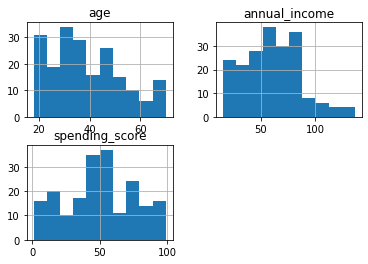

In [23]:
mall_df.hist()

In [28]:
mall_df = remove_outliers(mall_df, 1.7, ['age', 'annual_income', 'spending_score'])

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'annual_income'}>],
       [<AxesSubplot:title={'center':'spending_score'}>, <AxesSubplot:>]],
      dtype=object)

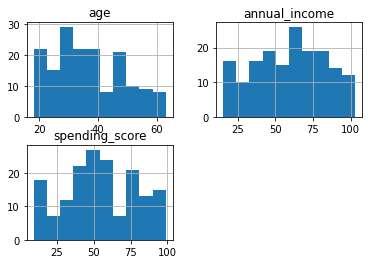

In [29]:
mall_df.hist()

## Split data (train, validate, and test split).

In [ ]:
def split_continuous(df):
    '''
    Takes in a df
    Returns train, validate, and test DataFrames
    '''
    # Create train_validate and test datasets
    train_validate, test = train_test_split(df, 
                                        test_size=.2, 
                                        random_state=123)
    # Create train and validate datsets
    train, validate = train_test_split(train_validate, 
                                   test_size=.3, 
                                   random_state=123)

    # Take a look at your split datasets

    print(f'train -> {train.shape}')
    print(f'validate -> {validate.shape}')
    print(f'test -> {test.shape}')
    
    return train, validate, test

In [32]:
# create train_validate and test datasets
train_validate, test = train_test_split(df, 
                                        test_size =.2, 
                                        random_state=123)

# Create train and validate datsets
train, validate = train_test_split(train_validate, 
                                   test_size=.3, 
                                   random_state=123)

# Take a look at your split datasets

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (29225, 68)
validate -> (12525, 68)
test -> (10438, 68)


## Encode categorical columns using a one hot encoder (pd.get_dummies).

## Handles missing values.

In [36]:
# No missing values in mall_df

In [37]:
missing_values_table(mall_df)

Your selected dataframe has 4 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Scaling

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled')

# wrangle_mall.py

### Write a function that:
- Acquires data from mall_customers.customers in mysql database.
- Splits the data into train, validate, and split
- One-hot-encodes (pd.get_dummies)
- Handles Missing values
- Scales

In [ ]:
def wrangle_mall_df():

    # acquire data
    sql = 'select * from customers'


    # acquire data from SQL server
    mall_df = get_mall_customers(sql)

    # handle outliers
    mall_df = outlier_function(mall_df, ['age', 'spending_score', 'annual_income'], 1.5)

    # get dummy for gender column
    dummy_df = pd.get_dummies(mall_df.gender, drop_first=True)
    mall_df = pd.concat([mall_df, dummy_df], axis=1).drop(columns = ['gender'])

    train, validate, test = train_validate_test_split(mall_df)

    return min_max_scaler(train, validate, test)